In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

sys.path.append(str(Path("..").resolve()))
from config.settings import DATA_RAW, DATA_PROCESSED

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:,.2f}".format)
sns.set_theme(style="whitegrid", palette="muted")

print("✅ Imports OK")

✅ Imports OK


In [2]:
df = pd.read_parquet(DATA_RAW / "secop_raw.parquet")

# Add year column — we'll use this throughout
df["year"] = df["fecha_de_inicio_del_contrato"].dt.year
df["month"] = df["fecha_de_inicio_del_contrato"].dt.month
df["quarter"] = df["fecha_de_inicio_del_contrato"].dt.quarter

print(f"Loaded {len(df):,} rows")

Loaded 1,500,000 rows


In [3]:
# The max value (9.97T COP) is a data entry error
# We cap at 99.9th percentile for all visualizations
# We do NOT drop these rows — we flag them as a feature later

cap_value = df["valor_del_contrato"].quantile(0.999)
print(f"99.9th percentile cap: {cap_value:,.0f} COP")
print(f"Contracts above cap:   {(df['valor_del_contrato'] > cap_value).sum():,}")

df["valor_capped"] = df["valor_del_contrato"].clip(upper=cap_value)
df["log_valor"] = np.log10(df["valor_del_contrato"].clip(lower=1))

99.9th percentile cap: 20,000,033,621 COP
Contracts above cap:   1,500


Direct Award Rate by Sector (min 1,000 contracts):

  Inclusión Social y Reconciliación              98.2%  ████████████████████████████████
  Información Estadística                        98.0%  ████████████████████████████████
  Salud y Protección Social                      96.4%  ████████████████████████████████
  deportes                                       95.8%  ███████████████████████████████
  Ciencia Tecnología                             95.4%  ███████████████████████████████
  interior                                       95.2%  ███████████████████████████████
  Planeación                                     95.1%  ███████████████████████████████
  Vivienda, Ciudad y Territorio                  94.8%  ███████████████████████████████
  agricultura                                    94.8%  ███████████████████████████████
  Industria                                      94.1%  ███████████████████████████████
  Educación Nacional                             93.8%  █████████

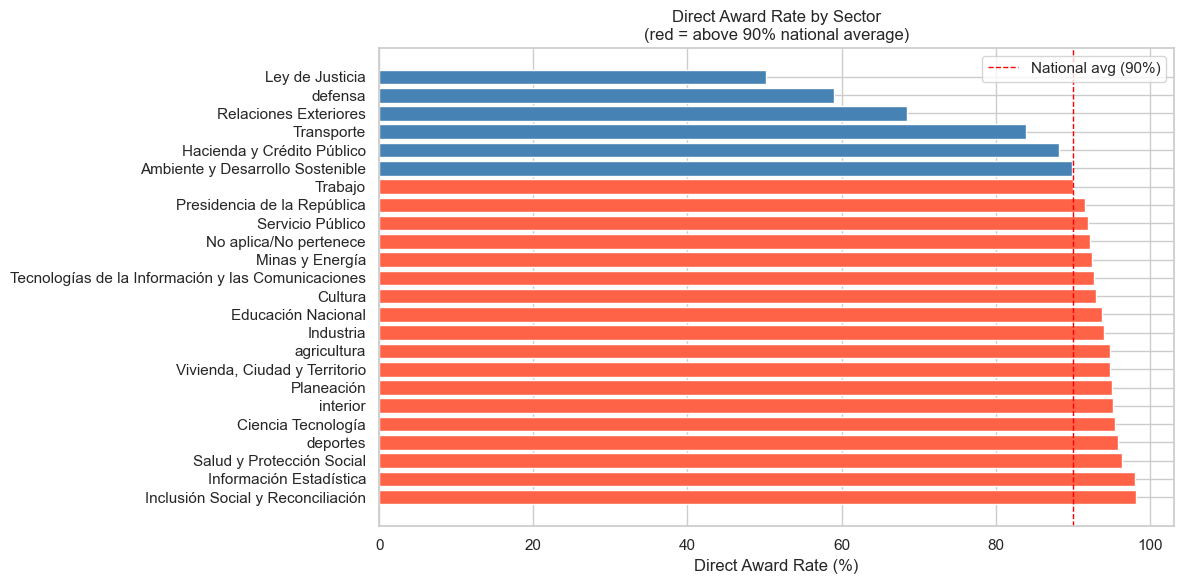

In [4]:
# Define direct award flag
direct_keywords = ["directa", "régimen especial"]
df["is_direct"] = df["modalidad_de_contratacion"].str.lower().str.contains(
    "|".join(direct_keywords), na=False
).astype(int)

# By sector
sector_stats = df.groupby("sector").agg(
    contracts=("id_contrato", "count"),
    direct_rate=("is_direct", "mean"),
    total_spend=("valor_del_contrato", "sum")
).reset_index()

sector_stats = sector_stats[sector_stats["contracts"] >= 1000]
sector_stats = sector_stats.sort_values("direct_rate", ascending=False)
sector_stats["direct_rate_pct"] = sector_stats["direct_rate"] * 100

print("Direct Award Rate by Sector (min 1,000 contracts):\n")
for _, row in sector_stats.iterrows():
    bar = "█" * int(row.direct_rate_pct / 3)
    print(f"  {row.sector:<45} {row.direct_rate_pct:>5.1f}%  {bar}")

# Chart
fig, ax = plt.subplots(figsize=(12, 6))
colors = ["tomato" if r > 0.90 else "steelblue" for r in sector_stats["direct_rate"]]
ax.barh(sector_stats["sector"], sector_stats["direct_rate_pct"], color=colors)
ax.axvline(90, color="red", linestyle="--", linewidth=1, label="National avg (90%)")
ax.set_xlabel("Direct Award Rate (%)")
ax.set_title("Direct Award Rate by Sector\n(red = above 90% national average)")
ax.legend()
plt.tight_layout()
plt.savefig("../outputs/charts/02_direct_rate_by_sector.png", dpi=150)
plt.show()

Top 15 Departments by Direct Award Rate:

                            departamento  contracts  direct_rate
San Andrés, Providencia y Santa Catalina      11551         0.94
                         Valle del Cauca     158936         0.94
                                 Quindío      27100         0.93
                               Atlántico      47538         0.93
              Distrito Capital de Bogotá     641108         0.92
                               Risaralda      30129         0.91
                               Magdalena      12020         0.91
                               Santander      61028         0.90
                                Casanare      16329         0.90
                                 Bolívar      36979         0.90
                      Norte de Santander      28412         0.89
                                   Sucre      13378         0.89
                                  Tolima      37538         0.89
                                   Cauca      19

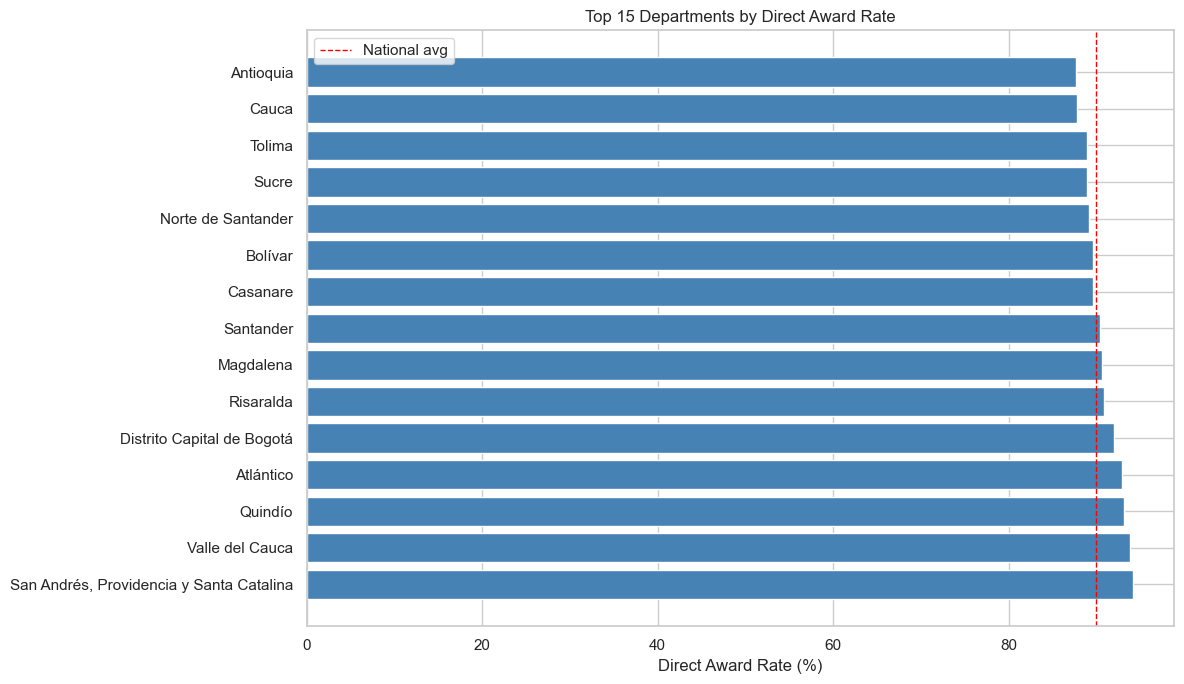

In [5]:
dept_stats = df.groupby("departamento").agg(
    contracts=("id_contrato", "count"),
    direct_rate=("is_direct", "mean"),
    total_spend=("valor_del_contrato", "sum")
).reset_index()

dept_stats = dept_stats[dept_stats["contracts"] >= 2000]
dept_stats = dept_stats.sort_values("direct_rate", ascending=False)

print("Top 15 Departments by Direct Award Rate:\n")
print(dept_stats.head(15)[["departamento", "contracts", "direct_rate"]].to_string(index=False))

fig, ax = plt.subplots(figsize=(12, 7))
top15 = dept_stats.head(15)
ax.barh(top15["departamento"], top15["direct_rate"] * 100, color="steelblue")
ax.axvline(90, color="red", linestyle="--", linewidth=1, label="National avg")
ax.set_xlabel("Direct Award Rate (%)")
ax.set_title("Top 15 Departments by Direct Award Rate")
ax.legend()
plt.tight_layout()
plt.savefig("../outputs/charts/02_direct_rate_by_dept.png", dpi=150)
plt.show()

Log10(Contract Value) by Award Type:

                        mean  median    count
Competitive             7.59    7.52   149410
Direct/Non-competitive  7.35    7.33  1350590


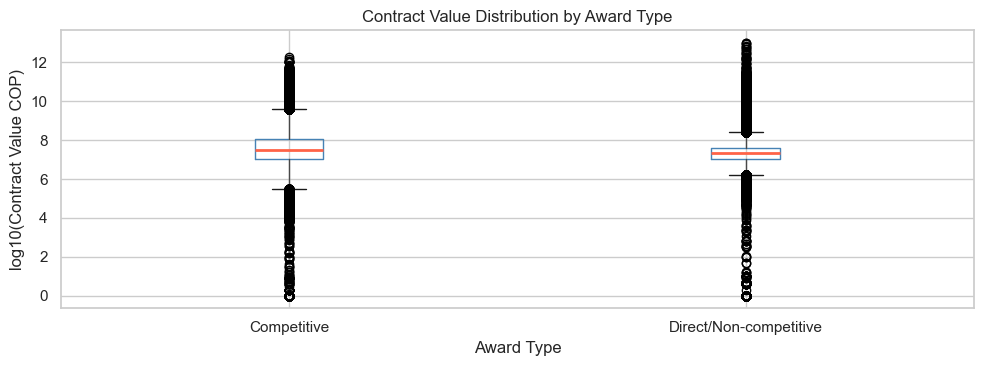

In [6]:
# Does direct award correlate with higher or lower contract values?
modality_value = df.groupby("is_direct")["log_valor"].agg(["mean", "median", "count"])
modality_value.index = ["Competitive", "Direct/Non-competitive"]
print("Log10(Contract Value) by Award Type:\n")
print(modality_value.to_string())

fig, ax = plt.subplots(figsize=(10, 4))
df.boxplot(column="log_valor", by="is_direct", ax=ax,
           boxprops=dict(color="steelblue"),
           medianprops=dict(color="tomato", linewidth=2))
ax.set_xticklabels(["Competitive", "Direct/Non-competitive"])
ax.set_xlabel("Award Type")
ax.set_ylabel("log10(Contract Value COP)")
ax.set_title("Contract Value Distribution by Award Type")
plt.suptitle("")
plt.tight_layout()
plt.savefig("../outputs/charts/02_value_by_modality.png", dpi=150)
plt.show()

In [8]:
df["is_modified"] = (df["estado_contrato"] == "Modificado").astype(int)
df["dias_adicionados"] = pd.to_numeric(df["dias_adicionados"], errors="coerce").fillna(0)

print("Modification Analysis:")
print(f"  Modified contracts:        {df['is_modified'].sum():,} ({df['is_modified'].mean()*100:.1f}%)")
print(f"  Avg days added (modified): {df[df['is_modified']==1]['dias_adicionados'].mean():,.0f}")
print(f"  Avg days added (all):      {df['dias_adicionados'].mean():,.0f}")

# Modified rate by sector
mod_by_sector = df.groupby("sector")["is_modified"].mean().sort_values(ascending=False)
mod_by_sector = mod_by_sector[df.groupby("sector")["id_contrato"].count() >= 1000]

print("\nModification Rate by Sector (top 10):\n")
print((mod_by_sector.head(10) * 100).round(1).to_string())

Modification Analysis:
  Modified contracts:        266,002 (17.7%)
  Avg days added (modified): 46
  Avg days added (all):      8

Modification Rate by Sector (top 10):

sector
Salud y Protección Social           43.40
Ciencia Tecnología                  26.00
Inclusión Social y Reconciliación   23.90
Ley de Justicia                     17.90
Cultura                             17.70
agricultura                         17.70
Vivienda, Ciudad y Territorio       16.60
Transporte                          15.90
deportes                            14.80
Minas y Energía                     14.70


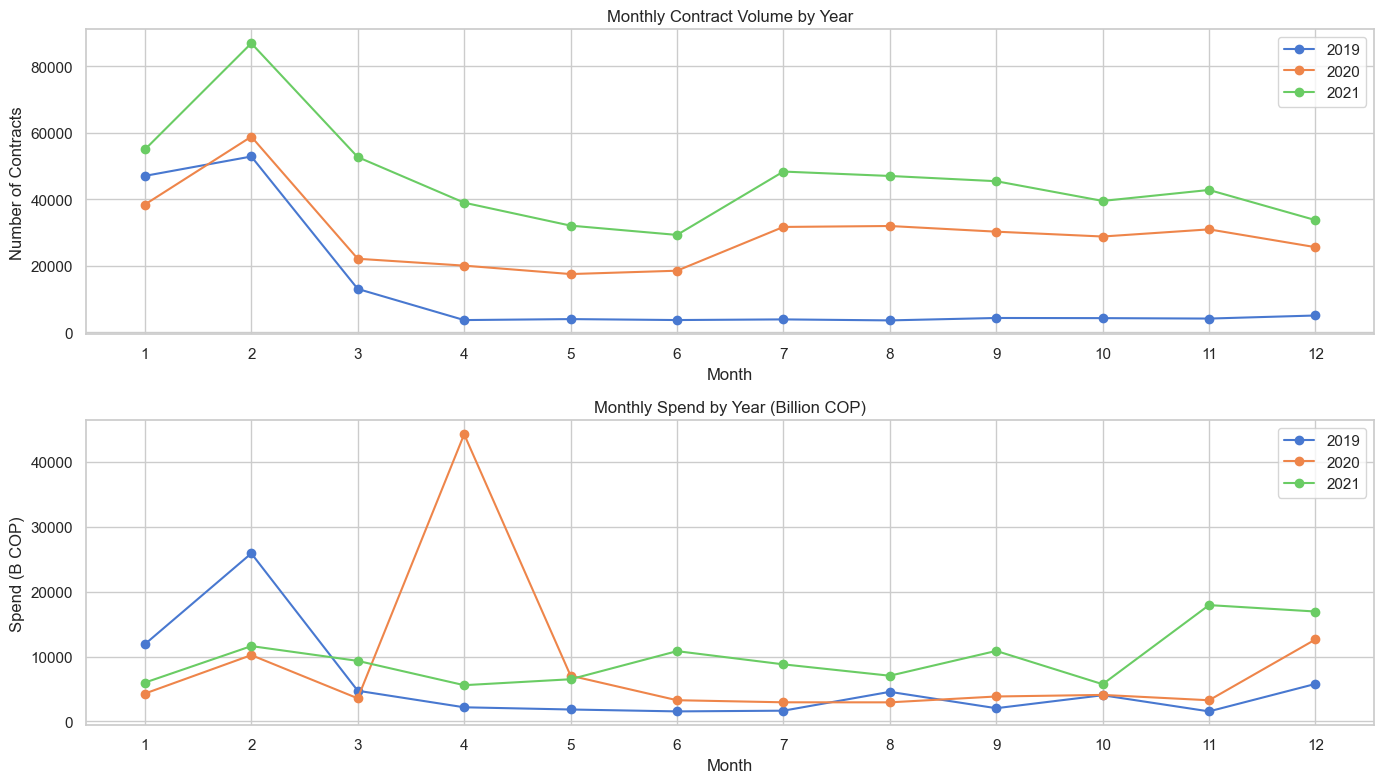

Q4 share of contracts: 14.3%
Q4 direct award rate:  78.6%


In [10]:
# Governments often rush contracts at fiscal year end (Oct-Dec)
# This is a known risk pattern

monthly = df.groupby(["year", "month"]).agg(
    contracts=("id_contrato", "count"),
    spend=("valor_del_contrato", "sum")
).reset_index()

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

for year in [2019, 2020, 2021]:
    subset = monthly[monthly["year"] == year]
    axes[0].plot(subset["month"], subset["contracts"], marker="o", label=str(year))
    axes[1].plot(subset["month"], subset["spend"] / 1e9, marker="o", label=str(year))

axes[0].set_title("Monthly Contract Volume by Year")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Number of Contracts")
axes[0].legend()
axes[0].set_xticks(range(1, 13))

axes[1].set_title("Monthly Spend by Year (Billion COP)")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Spend (B COP)")
axes[1].legend()
axes[1].set_xticks(range(1, 13))

plt.tight_layout()
plt.savefig("../outputs/charts/02_monthly_patterns.png", dpi=150)
plt.show()

# Flag Q4 (fiscal year end pressure)
q4_rate = (df["quarter"] == 4).mean()
q4_direct = df[df["quarter"] == 4]["is_direct"].mean()
print(f"Q4 share of contracts: {q4_rate*100:.1f}%")
print(f"Q4 direct award rate:  {q4_direct*100:.1f}%")

Vendor Concentration:
  Total vendors:          544,813
  Top 1 vendor share:     2.86%
  Top 10 vendor share:    18.91%
  Top 100 vendor share:   42.10%


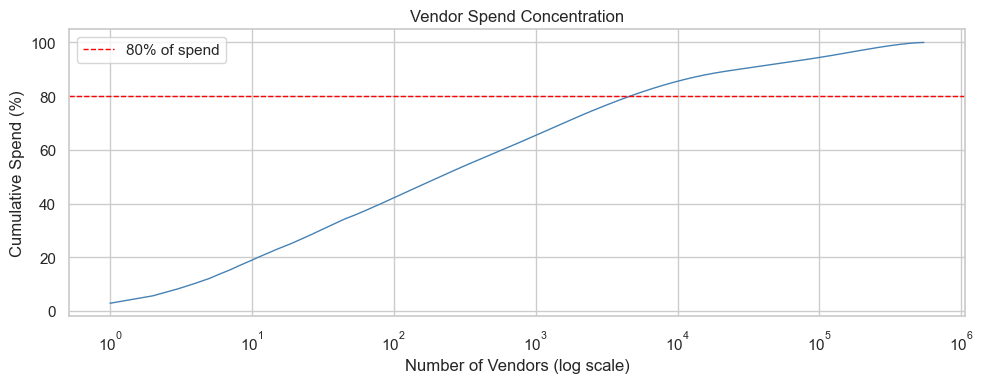

In [11]:
# How concentrated is spend among top vendors?
vendor_spend = df.groupby("codigo_proveedor")["valor_del_contrato"].sum().sort_values(ascending=False)
total_spend = vendor_spend.sum()

top1_share = vendor_spend.iloc[0] / total_spend * 100
top10_share = vendor_spend.iloc[:10].sum() / total_spend * 100
top100_share = vendor_spend.iloc[:100].sum() / total_spend * 100

print("Vendor Concentration:")
print(f"  Total vendors:          {len(vendor_spend):,}")
print(f"  Top 1 vendor share:     {top1_share:.2f}%")
print(f"  Top 10 vendor share:    {top10_share:.2f}%")
print(f"  Top 100 vendor share:   {top100_share:.2f}%")

# Lorenz-style cumulative chart
cumulative = vendor_spend.cumsum() / total_spend * 100
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(range(1, len(cumulative) + 1), cumulative.values, color="steelblue", linewidth=1)
ax.axhline(80, color="red", linestyle="--", linewidth=1, label="80% of spend")
ax.set_xscale("log")
ax.set_xlabel("Number of Vendors (log scale)")
ax.set_ylabel("Cumulative Spend (%)")
ax.set_title("Vendor Spend Concentration")
ax.legend()
plt.tight_layout()
plt.savefig("../outputs/charts/02_vendor_concentration.png", dpi=150)
plt.show()

In [12]:
print("=" * 60)
print("EDA SUMMARY — KEY FINDINGS")
print("=" * 60)
print(f"1. Direct award rate:      {df['is_direct'].mean()*100:.1f}% of all contracts")
print(f"2. Modification rate:      {df['is_modified'].mean()*100:.1f}% of all contracts")
print(f"3. Total vendors:          {df['codigo_proveedor'].nunique():,}")
print(f"4. Total agencies:         {df['codigo_entidad'].nunique():,}")
print(f"5. Total spend analyzed:   {df['valor_del_contrato'].sum()/1e12:.2f} trillion COP")
print(f"6. COVID spike visible:    2020 volume 2.4x vs 2019")
print(f"7. Q4 direct award rate:   {df[df['quarter']==4]['is_direct'].mean()*100:.1f}%")
print("=" * 60)

# Save enriched dataframe for next notebook
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)
df.to_parquet(DATA_PROCESSED / "secop_eda.parquet", index=False, compression="snappy")
print("\n✅ EDA complete. Saved enriched data to data/processed/secop_eda.parquet")

EDA SUMMARY — KEY FINDINGS
1. Direct award rate:      90.0% of all contracts
2. Modification rate:      17.7% of all contracts
3. Total vendors:          544,813
4. Total agencies:         2,359
5. Total spend analyzed:   348.94 trillion COP
6. COVID spike visible:    2020 volume 2.4x vs 2019
7. Q4 direct award rate:   78.6%

✅ EDA complete. Saved enriched data to data/processed/secop_eda.parquet
